# FBU for ttbarAC
Unfold results from the charge asymmetry analysis using FBU.

In [1]:
# enable your grid access (using the terminal)
!xrdcp root://cmsxrootd.fnal.gov//store/user/demarley/lpc/unfolding-hats/hists.root ~

[6.628kB/6.628kB][100%][==================================================][6.628kB/s]  


In [1]:
import numpy as np
import fbu
import uproot
import utils

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Load data from the ROOT file using `uproot`

In [2]:
f = uproot.open("/home/dmarley/hists.root")

Within the file are the different histograms necessary for the unfolding.

In [3]:
uresmat  = f['resmat_p']   # response matrix
uttbar   = f['ttbar']      # ttbar
uwjets   = f['wjets']      # w+jets
ustop    = f['singletop']  # single top
udiboson = f['diboson']    # diboson
uzjets   = f['zjets']      # zjets
utruth   = f['truth']      # MC truth distribution

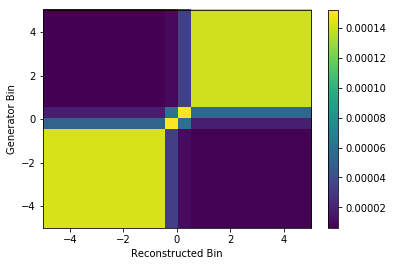

In [4]:
response = uresmat.numpy
utils.plotResponseMatrix(response[0],bins=response[1])

In [5]:
# bin content for each background
backgrounds = {'wjets':uwjets.numpy[0],
               'zjets':uzjets.numpy[0],
               'diboson':udiboson.numpy[0],
               'singletop':ustop.numpy[0]}

In [6]:
nttbar = uttbar.numpy[0]
nwjets = uwjets.numpy[0]
nzjets = uzjets.numpy[0]
ndiboson = udiboson.numpy[0]
nstop  = ustop.numpy[0]
asimov = nttbar + nwjets + nzjets + nstop + ndiboson

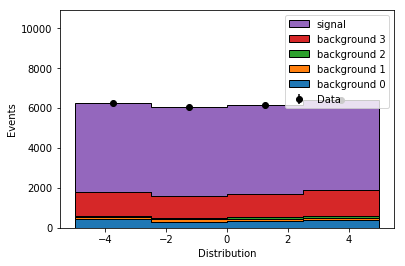

In [11]:
utils.plotYields(asimov,signal=uttbar.numpy[0],
                backgrounds=[nzjets,ndiboson,nstop,nwjets],
                bins=uttbar.numpy[1].tolist())

Run FBU!

In [12]:
myfbu = fbu.PyFBU()

In [13]:
myfbu.data       = uttbar.numpy[0]
myfbu.response   = response[0].tolist()
myfbu.background = backgrounds

unf_truth = utruth.numpy[0]
myfbu.lower = [i*0.2 for i in unf_truth]   # lower bound on hyperbox
myfbu.upper = [2*i for i in unf_truth]     # upper bound on hyperbox
myfbu.nMCMC = 200000        # number of samplings
myfbu.monitoring = False    # diagnostics

In [14]:
myfbu.run()

Assigned Metropolis to truth0
Assigned Metropolis to truth1
Assigned Metropolis to truth2
Assigned Metropolis to truth3
100%|██████████| 201000/201000 [01:44<00:00, 1920.07it/s]


Retrieve the N-dimensional posterior distribution in the form of a list of N arrays.

In [15]:
trace = myfbu.trace
print "> Trace = ",trace 
print "> Size of trace     = ",len(trace)
print "> Entries per trace = ",len(trace[0])

> Trace =  [array([21977302, 22124070, 22701302, ..., 20872199, 21319289, 21528082]), array([15869336, 15856041, 16075449, ..., 17450849, 17450849, 17175656]), array([16893373, 16893373, 16847083, ..., 15835804, 15929047, 15348852]), array([22231739, 22517290, 22595540, ..., 23446693, 23220482, 23519286])]
> Size of trace     =  4
> Entries per trace =  200000


Each array corresponds to the projection of the posterior distribution for a given bin.

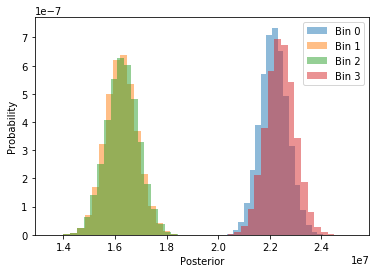

In [16]:
utils.plotPosteriors(trace)

For each unfolded bin, we can extract the mean and RMS.

In [17]:
utils.printPosteriors(trace)

 > Bin 0: 22154342.74 ± 536751.13
 > Bin 1: 16243580.22 ± 610067.63
 > Bin 2: 16278700.45 ± 629201.39
 > Bin 3: 22406663.90 ± 562532.00


In [18]:
neg = sum( np.mean(unf_truth[i]) for i in range(2))
pos = sum( np.mean(unf_truth[i]) for i in range(2,4) )

truth_ac = (pos-neg)/(pos+neg)
print truth_ac

0.003893320592006658


In [20]:
unfacs = [utils.computeAC(bins) for bins in zip(*trace)]
ac     = np.mean(unfacs)
acerr  = np.std(unfacs)
print ac,acerr

0.0037283747750098714 0.012844184223198487


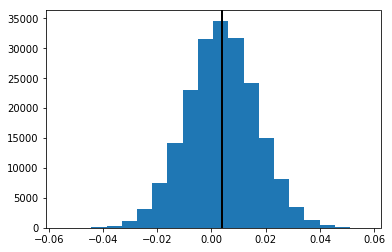

In [26]:
import matplotlib.pyplot as plt
_ = plt.hist(unfacs,bins=20)
_ = plt.axvline(x=truth_ac,color='k',lw=2)

In [22]:
# Compare unfolded bin values with the truth-level predictions
print " > Bin 0: {0}".format(unf_truth[0]-np.mean(trace[0]))
print " > Bin 1: {0}".format(unf_truth[1]-np.mean(trace[1]))
print " > Bin 0: {0}".format(unf_truth[2]-np.mean(trace[2]))
print " > Bin 1: {0}".format(unf_truth[3]-np.mean(trace[3]))

 > Bin 0: -3804.735535
 > Bin 1: -9175.216235
 > Bin 0: 2316.54689
 > Bin 1: -2679.90338


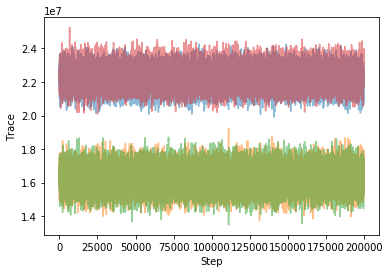

In [25]:
utils.plotTrace(trace)